Importing modules.



In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

Load the data.

In [ ]:
data = pd.read_csv("/content/Nat_Gas.csv", index_col=[0], parse_dates=[0])

<ipython-input-21-bb74701edfc1>:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



I'll be using an ARIMA model for time series forecasting.

In [ ]:
#testing for stationarity using Augmented Dickey-Fuller Test
def adfuller_test (x):
  result = adfuller (x)
  print (f"Test Statistic: {result[0]}")
  print (f"p-value: {result[1]}")

  if result[1] > 0.05:
    print ("This data is Non-stationary and needs differencing")
  else:
   print ("No differencing is needed")

adfuller_test (data["Prices"])

Test Statistic: 0.21807686169999427
p-value: 0.973257438844869
This data is Non-stationary and needs differencing


In [ ]:
#differencing the data
data_diff = data.diff().dropna()
adfuller_test (data_diff["Prices"])

Test Statistic: -6.844773557477344
p-value: 1.754169685294091e-09
No differencing is needed


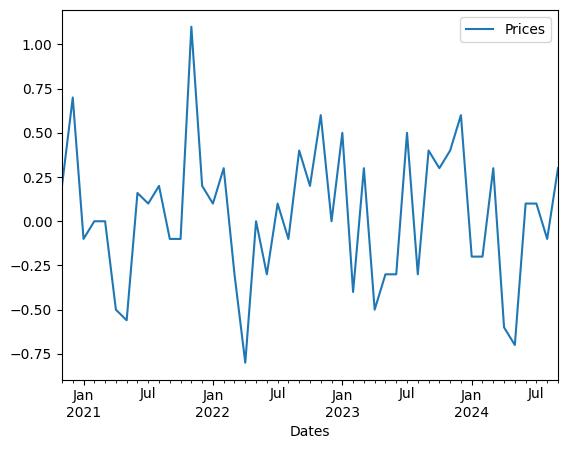

In [ ]:
fig, ax = plt.subplots()
data_diff.plot(ax= ax)
plt.show()

Next, I split the data into train and test sets.

In [ ]:
# Instead of using the length of the DataFrame, use the date 30 days prior to the last date
msk = (data.index < data.index[-1] - pd.DateOffset(days=30))
train = data[msk].copy()
test = data[~msk].copy()

In [ ]:
train_data = data.loc[:"2023"]
train_test = data.loc["2023":]

To determine my AR and MA, I use a Partial ACF and an ACF plot.

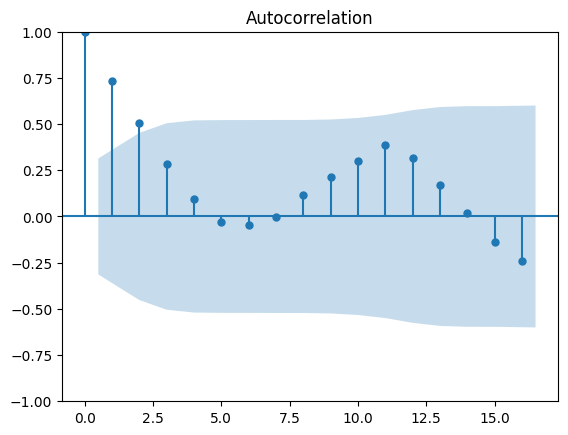

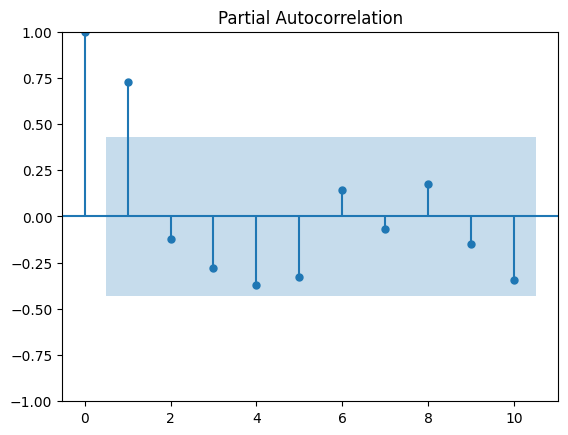

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(train_data)
pacf_original = plot_pacf(train_test)

From the plots, I'll be using an AR of 3 and an MA of 1. To check how accurate my values are, I'll use an automatic arima model fit in Python to get the values.

In [ ]:
import pmdarima as pm
auto_arima = pm.auto_arima(train_data, stepwise=False, seasonal = False)
auto_arima

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
data.index = data.index.to_period("M")

Fit the model.

In [ ]:
model = ARIMA (data, order= (3,1,1))
model_results = model.fit()
print (model_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 Prices   No. Observations:                   48
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 -21.954
Date:                Sun, 20 Oct 2024   AIC                             53.908
Time:                        19:12:59   BIC                             63.159
Sample:                    10-31-2020   HQIC                            57.389
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0373    765.655   4.88e-05      1.000   -1500.618    1500.693
ar.L2          0.1132     53.044      0.002      0.998    -103.850     104.077
ar.L3          0.0038     84.939   4.44e-05      1.0

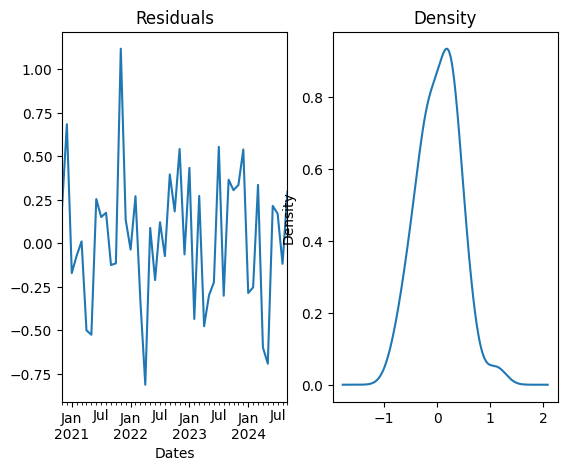

In [ ]:
residuals = model_results.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax=ax[0])
residuals.plot(title = "Density", kind="kde", ax=ax[1])
plt.show()

<Axes: xlabel='Dates'>

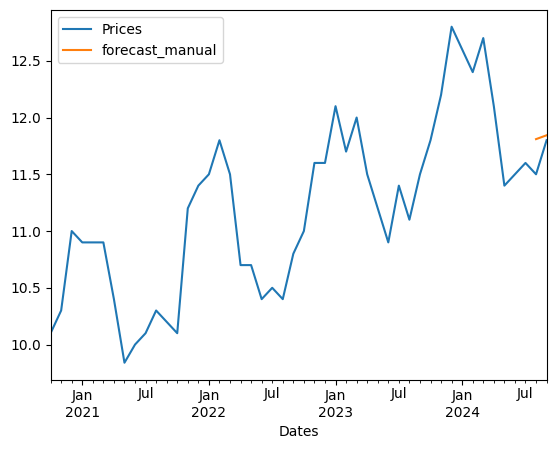

In [ ]:
forecast_test = model_results.forecast(len(test))
data["forecast_manual"] =[None]*len(train)+list(forecast_test)
data.plot()

Checking the Standard Error:

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

print(f"MAE:{mean_absolute_error (test, forecast_test)}")
print(f"MAPE:{mean_absolute_percentage_error (test, forecast_test)}")
print(f"RMSE:{np.sqrt(mean_squared_error (test, forecast_test))}")

MAE:0.17667171284866434
MAPE:0.015314517611723224
RMSE:0.2211561127024959


Looking at the ACF and PACF plot of our AR and MA model, we can see that it is quite reliable.

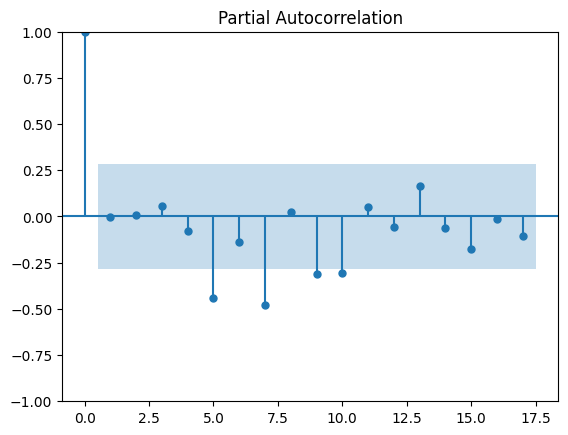

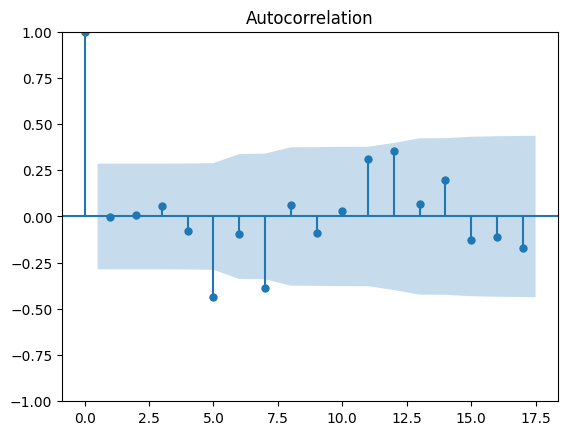

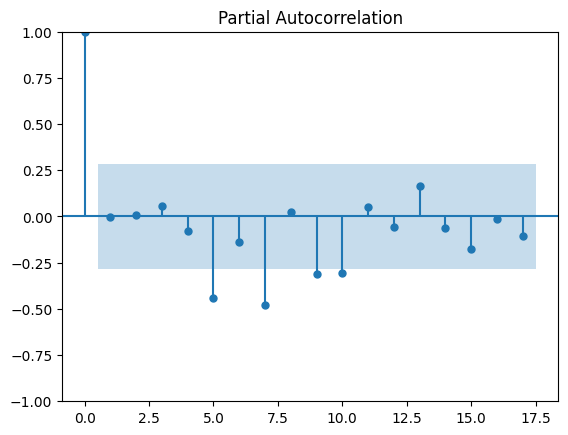

In [ ]:
plot_acf(residuals)
plot_pacf (residuals)

# Finally, I forecast for the next year.

In [ ]:
forecast = model_results.get_forecast(steps=12)
forecast_index = pd.date_range("2024-10", periods=12, freq="M").to_period("M")
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_df = pd.DataFrame({"Forecast": forecast_values}, index=forecast_index)
full_data = pd.concat([data, forecast_df])

forecast_df.index = forecast_df.index.astype(str)
full_data.index = full_data.index.astype(str)

fig = px.line(full_data, title="Natural Gas Prices with Forecast")
fig.add_scatter(x=forecast_df.index, y=forecast_df["Forecast"],
                name='Forecast', line=dict(color='red'))
fig.show()

<ipython-input-39-ebfe39f62fc3>:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

